In [1]:
import pandas as pd
train = pd.read_parquet('train_dataset_hackaton2023_train.gzip')
test = pd.read_parquet('hackaton2023_test.gzip')

In [2]:
mapping = pd.read_csv('mapping.csv', index_col=0)

In [3]:
train['dish_cat'] = train.dish_name.map(mapping.to_dict()['dish_category'])

In [4]:
train_X = pd.DataFrame()

In [5]:
import numpy as np
train_X['mean_bill'] = train.groupby(['customer_id', 'startdatetime']).revenue.sum().groupby('customer_id').mean()
train_X['mean_time'] = train.groupby(['customer_id', 'startdatetime']).startdatetime.first().groupby('customer_id').diff().groupby('customer_id').mean().dt.total_seconds()
train_X['range_time'] = train.groupby(['customer_id', 'startdatetime']).startdatetime.first().groupby('customer_id').agg(['min', 'max']).diff(axis = 1)['max'].dt.total_seconds()
train_X['mean_rest_size'] = train.groupby(['customer_id']).ownareaall_sqm.mean()
train_X['last_rest'] = train.groupby(['customer_id']).format_name.last()
train_X['most_freq_dish_cat'] = train.groupby(['customer_id'])['dish_cat'].agg(pd.Series.mode).apply(lambda x: x[0] if type(x)==np.ndarray else x)
train_X['most_freq_rest'] = train.groupby(['customer_id'])['format_name'].agg(pd.Series.mode).apply(lambda x: x[0] if type(x)==np.ndarray else x)
train['discounts'] = train['revenue'] ==1
train_X['discounts'] = (train.groupby(['customer_id']).discounts).sum()
train_X['counts_of_buy'] = (train.groupby(['customer_id', 'startdatetime'])).startdatetime.first().groupby('customer_id').count()
train_X['counts_of_positions'] = (train.groupby(['customer_id'])).revenue.count()

In [6]:
train_Y_cat = np.array(train.groupby('customer_id').buy_post.first())
train_Y_reg = np.array(train.groupby('customer_id').date_diff_post.first())
train_Y_reg[np.isnan(train_Y_reg)] = 0

In [7]:
from catboost import Pool, cv


cat_features = [4,5,6]

cv_dataset = Pool(data=train_X,
                  label=train_Y_cat,
                  cat_features=cat_features)

params = {"iterations": 100,
          "depth": 5,
          "verbose": False,
            "loss_function": "Logloss",
            "custom_metric":['F1', 'AUC']}

scores, models = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True",
            return_models='True')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5249809944
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5254997167
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5237089235
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5254199855
bestIteration = 99

Training on fold [4/5]

bestTest = 0.5257739531
bestIteration = 99



In [8]:
scores.iloc[-1]

iterations            99.000000
test-Logloss-mean      0.525077
test-Logloss-std       0.000816
train-Logloss-mean     0.524918
train-Logloss-std      0.000211
test-F1-mean           0.837153
test-F1-std            0.000716
train-F1-mean          0.837194
train-F1-std           0.000207
test-AUC-mean          0.728761
test-AUC-std           0.001274
Name: 99, dtype: float64

<Axes: ylabel='Feature'>

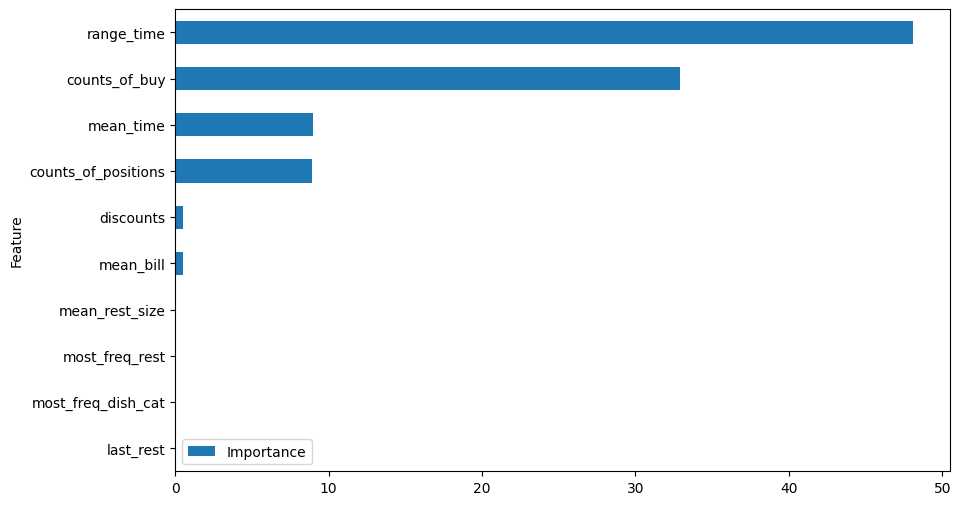

In [9]:

coefficients = models[0].get_feature_importance(cv_dataset)

feature_importance = pd.DataFrame({'Feature': train_X.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [10]:
cv_dataset = Pool(data=train_X,
                  label=train_Y_reg,
                  cat_features=cat_features)

params = {"iterations": 100,
          "depth": 5,
          "verbose": False,
            "loss_function": "RMSE"}

scores, models_reg = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True",
            return_models='True')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 16.92161732
bestIteration = 99

Training on fold [1/5]

bestTest = 16.91771659
bestIteration = 99

Training on fold [2/5]

bestTest = 16.90535791
bestIteration = 99

Training on fold [3/5]

bestTest = 16.80832927
bestIteration = 99

Training on fold [4/5]

bestTest = 16.9339163
bestIteration = 99



In [11]:
scores.iloc[-1]

iterations         99.000000
test-RMSE-mean     16.897387
test-RMSE-std       0.050817
train-RMSE-mean    16.895567
train-RMSE-std      0.012693
Name: 99, dtype: float64

<Axes: ylabel='Feature'>

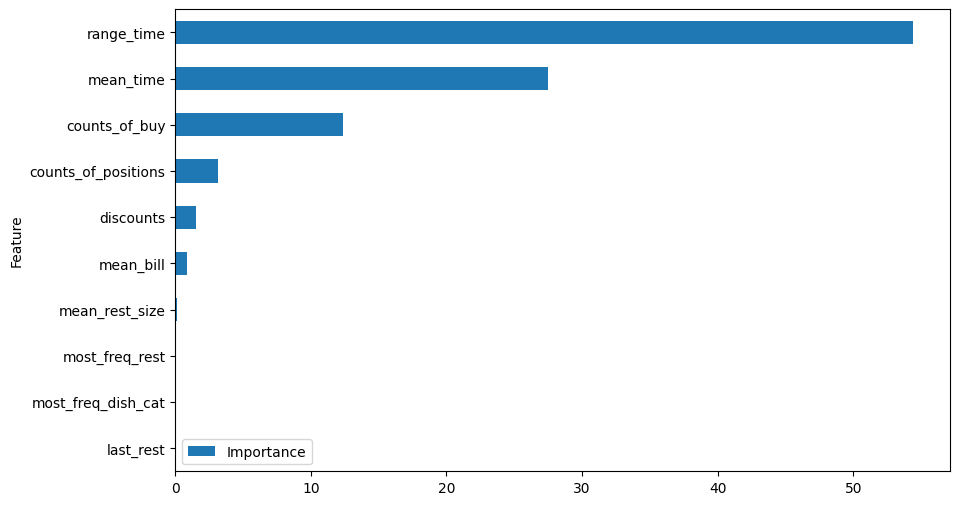

In [12]:
coefficients = models_reg[0].get_feature_importance(cv_dataset)

feature_importance = pd.DataFrame({'Feature': train_X.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))